# Fetch data

In [1]:
# get GPU info

!nvidia-smi

Sun Feb 20 11:02:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# # Mount google drive to colab-session

from google.colab import drive
drive.mount('/content/drive')

In [3]:
# get the dataset from drive

!cp "/content/drive/MyDrive/colab/NLP/quora_question_pair_similarity/data/data.csv" data.csv

# Module Import

In [6]:
import os, re
import pickle
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Embedding
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, RNN, Dropout
from tensorflow.keras.layers import BatchNormalization, concatenate
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [8]:
!pip install transformers==2.11.0

     |████████████████████████████████| 674 kB 5.2 MB/s 
     |████████████████████████████████| 5.6 MB 44.5 MB/s 
     |████████████████████████████████| 1.2 MB 47.2 MB/s 
     |████████████████████████████████| 895 kB 47.6 MB/s 


In [9]:
import transformers

# Dataset

In [10]:
class Dataset(keras.utils.Sequence):

  def __init__(self, df, max_length, batch, shuffle=True):

    self.df=df[['question1', 'question2', 'is_duplicate']]
    self.max_length=max_length
    self.batch=batch
    self.shuffle=shuffle

    self.tokenizer=transformers.BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
    self.indexes = np.arange(df.shape[0])

  def __len__(self):
    return self.df.shape[0]//self.batch

  def __getitem__(self, index):
    i=index * self.batch 
    j=min( (index + 1) * self.batch, self.df.shape[0])

    df_temp=df.iloc[i:j,:]
    ques_pairs=df_temp[['question1', 'question2']].values.astype("str").tolist()
    out=df_temp['is_duplicate'].values

    encoded = self.tokenizer.batch_encode_plus(
                ques_pairs,
                add_special_tokens=True,
                max_length=self.max_length,
                return_attention_mask=True,
                return_token_type_ids=True,
                pad_to_max_length=True,
                return_tensors="tf", )

    input_id = np.array(encoded["input_ids"], dtype="int32")
    attention_mask = np.array(encoded["attention_mask"], dtype="int32")
    token_type_id  = np.array(encoded["token_type_ids"], dtype="int32")

    return ([input_id, attention_mask, token_type_id], out)


  def on_epoch_end(self):
    if self.shuffle:
      np.random.shuffle(self.indexes)


In [11]:
# read data file

df=pd.read_csv("data.csv")
df.shape

(404290, 6)

In [12]:
max_length=40
batch=512

N=df.shape[0]
N2=int(N*0.80)

train_df=df.iloc[:N2, :]
test_df=df.iloc[N2:, :]

train_dataset=Dataset(train_df, max_length, batch)
test_dataset=Dataset(test_df, max_length, batch)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [13]:
train_df.shape, test_df.shape

((323432, 6), (80858, 6))

# Model

In [14]:
def create_model(max_length):
    id_input = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    attention_masks_input =Input(shape=(max_length,), dtype=tf.int32, name="attention_masks")
    token_type_ids_input = Input(shape=(max_length,), dtype=tf.int32, name="token_type_ids")

    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    bert_model.trainable = False

    sequence_out, pool_out = bert_model(id_input, 
                                                attention_mask=attention_masks_input, 
                                                token_type_ids=token_type_ids_input)

    bidir = Bidirectional(GRU(64, return_sequences=True))(sequence_out)
    
    avg_pool = GlobalAveragePooling1D()(bidir)
    max_pool = GlobalMaxPooling1D()(bidir)

    x = concatenate([avg_pool, max_pool])
    output = Dense(1, activation="sigmoid")(x)

    model = Model( inputs=[id_input, attention_masks_input, token_type_ids_input], outputs=output )  

    return model


In [15]:
K.clear_session()
model=create_model(max_length)
model.summary()

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 40)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 40)]         0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    ((None, 40, 768),    109482240   ['input_ids[0][0]',              
                                 (None, 768))                     'attention_masks[0][0]',    

# Train

In [16]:
loss="binary_crossentropy"

model.compile(optimizer=Adam(learning_rate=1E-3), loss=loss, metrics=["accuracy"])

In [17]:
epochs=10

history=model.fit(train_dataset, 
          epochs=epochs,
          validation_data=test_dataset)

Epoch 1/10
631/631 [==============================] - 2405s 4s/step - loss: 0.4102 - accuracy: 0.7998 - val_loss: 0.3407 - val_accuracy: 0.8435
Epoch 2/10
631/631 [==============================] - 2377s 4s/step - loss: 0.3445 - accuracy: 0.8409 - val_loss: 0.3042 - val_accuracy: 0.8646
Epoch 3/10
631/631 [==============================] - 2378s 4s/step - loss: 0.3194 - accuracy: 0.8552 - val_loss: 0.2830 - val_accuracy: 0.8758
Epoch 4/10
631/631 [==============================] - 2379s 4s/step - loss: 0.3015 - accuracy: 0.8643 - val_loss: 0.2704 - val_accuracy: 0.8819
Epoch 5/10
631/631 [==============================] - 2380s 4s/step - loss: 0.2889 - accuracy: 0.8713 - val_loss: 0.2479 - val_accuracy: 0.8937
Epoch 6/10
631/631 [==============================] - 2385s 4s/step - loss: 0.2755 - accuracy: 0.8785 - val_loss: 0.2360 - val_accuracy: 0.9004
Epoch 7/10
631/631 [==============================] - 2385s 4s/step - loss: 0.2655 - accuracy: 0.8832 - val_loss: 0.2321 - val_accuracy:

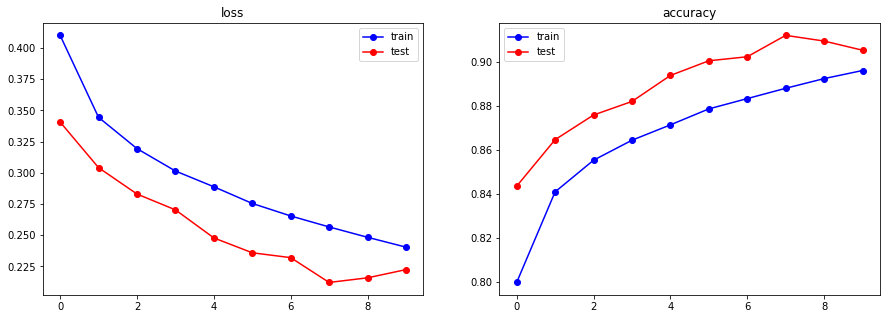

In [18]:
loss=history.history["loss"]
acc=history.history["accuracy"]
val_loss=history.history["val_loss"]
val_acc=history.history["val_accuracy"]

_, ax=plt.subplots(1,2,figsize=(15,5))
ax=ax.ravel()

ax[0].set_title("loss")
ax[0].plot(loss, "-bo")
ax[0].plot(val_loss, "-ro")
ax[0].legend(["train", "test"])

ax[1].set_title("accuracy")
ax[1].plot(acc, "-bo")
ax[1].plot(val_acc, "-ro")
ax[1].legend(["train", "test"])

plt.show()

The accuracy acheived is 91%